In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import pylab as pl
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8
import matplotlib.pyplot as pl
import seaborn as sns
from IPython.display import Image
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import matplotlib.pyplot as plt

In [2]:
import plotly
plotly.tools.set_credentials_file(username='leducsang97', api_key='3ccVqVkmejShTTYKhi3r')


# Objective

In this project, we will use Linear Regression (LR), Ridge Regression (Ridge), and Lasso Regression (Lasso) to answer the question: 

Was the Avocadopocalypse of 2017 real?

To answer this question, we will train the model base on other year and see if the average price in 2017 is normal or not.

# Clean data

In [3]:
data = pd.read_csv('avocado.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,47,2017-02-05,0.66,11274749.11,4377537.67,2558039.85,193764.89,4145406.70,2508731.79,1627453.06,9221.85,conventional,2017,West
1,47,2017-02-05,0.67,11213596.29,3986429.59,3550403.07,214137.93,3462625.70,3403581.49,7838.83,51205.38,conventional,2017,California
2,7,2018-02-04,0.80,10894677.77,4473811.63,4097591.67,146357.78,2176916.69,2072477.62,34196.27,70242.80,conventional,2018,California
3,7,2018-02-04,0.83,10565056.41,3121272.58,3294335.87,142553.21,4006894.75,1151399.33,2838239.39,17256.03,conventional,2018,West
4,46,2016-02-07,0.70,10361698.17,2930343.28,3950852.38,424389.60,3056112.91,2693843.02,344774.59,17495.30,conventional,2016,California


This data was downloaded from the [Hass Avocado Board website]('http://www.hassavocadoboard.com/retail/volume-and-price-data') in May of 2018 & compiled into a single CSV. Here's how the Hass Avocado Board describes the data on their website:

> The table below represents weekly 2018 retail scan data for National retail volume (units) and price. Retail scan data comes directly from retailers’ cash registers based on actual retail sales of Hass avocados. Starting in 2013, the table below reflects an expanded, multi-outlet retail data set. Multi-outlet reporting includes an aggregation of the following channels: grocery, mass, club, drug, dollar and military. The Average Price (of avocados) in the table reflects a per unit (per avocado) cost, even when multiple units (avocados) are sold in bags. The Product Lookup codes (PLU’s) in the table are only for Hass avocados. Other varieties of avocados (e.g. greenskins) are not included in this table.

Some relevant columns in the dataset:

- Date - The date of the observation
- AveragePrice - the average price of a single avocado
- type - conventional or organic
- year - the year
- Region - the city or region of the observation
- Total Volume - Total number of avocados sold
- 4046 - Total number of avocados with PLU 4046 sold
- 4225 - Total number of avocados with PLU 4225 sold
- 4770 - Total number of avocados with PLU 4770 sold

![avocado](avocado.png "")


Let get some background knowledge from [How to Identify Hass Avocados](https://loveonetoday.com/how-to/identify-hass-avocados/)

The most commonly sold sizes of fresh Hass avocado can be identified by their Product Lookup code or PLU or sticker. Avocados are also available for sale in netted bags. 

- Small/Medium Hass Avocado (~3-5oz avocado) | #4046

- Large Hass Avocado (~8-10oz avocado) | #4225

- Extra Large Hass Avocado (~10-15oz avocado) | #4770

Let get into our data

In [4]:
data.shape

(18080, 14)

In [5]:
data.isnull().sum()

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

The datasize is 18080 row with 14 column. This is very clean and nice data because there is no missing data.

## Explore data

In [6]:
plu_4046 = sum(data['4046'])
plu_4225 = sum(data['4225'])
plu_4770 = sum(data['4770'])
other = sum(data['Total Volume']) - sum([plu_4046,plu_4225,plu_4770])

In [7]:
#plot total of each type of avocado.
iplot([go.Bar(
            x=['PLU_4046', 'PLU_4225', 'PLU_4770','other'],
            y=[plu_4046, plu_4225, plu_4770, other]
    )]
)

We can see that the amount of other types of avocado is significant. The amount of PLU_4770 is small compare to other type of avocado. This is expected as it is the most expensive price per avocado. Let create column for other type of avocado and change the name of PLU 4046, PLU 4225, PLU 4770 to medium, large and extra large (easier to remember)

In [8]:
df = data
df = df.rename(index=str, columns={"4046": "Medium", "4225": "Large", "4770":"Extra Large"})
newCol = df['Total Volume'] - df["Medium"]-df["Large"]-df["Extra Large"]
df.insert(loc=7, column="Other", value=newCol)
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,Medium,Large,Extra Large,Other,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,47,2017-02-05,0.66,11274749.11,4377537.67,2558039.85,193764.89,4145406.70,4145406.70,2508731.79,1627453.06,9221.85,conventional,2017,West
1,47,2017-02-05,0.67,11213596.29,3986429.59,3550403.07,214137.93,3462625.70,3462625.70,3403581.49,7838.83,51205.38,conventional,2017,California
2,7,2018-02-04,0.80,10894677.77,4473811.63,4097591.67,146357.78,2176916.69,2176916.69,2072477.62,34196.27,70242.80,conventional,2018,California
3,7,2018-02-04,0.83,10565056.41,3121272.58,3294335.87,142553.21,4006894.75,4006894.75,1151399.33,2838239.39,17256.03,conventional,2018,West
4,46,2016-02-07,0.70,10361698.17,2930343.28,3950852.38,424389.60,3056112.91,3056112.91,2693843.02,344774.59,17495.30,conventional,2016,California


We use sns.heatmap to see the correlation between fundamental value. We drop the bags because the average price per avocado in different size of bags does not significantly different.

In [9]:
df = df.drop(['Total Bags', 'Small Bags', 'Large Bags','XLarge Bags','Unnamed: 0'], axis=1)

In [10]:
df_totalUS = df[df['region']=='TotalUS']
df_totalUS.head()

,Date,AveragePrice,Total Volume,Medium,Large,Extra Large,Other,type,year,region
1443,2018-02-18,1.52,1814929.97,246515.35,680037.45,1905.46,886471.71,organic,2018,TotalUS
1494,2018-03-18,1.54,1675804.22,170801.85,444949.69,1045.38,1059007.30,organic,2018,TotalUS
1502,2018-03-11,1.52,1664234.88,129169.72,408763.50,1401.87,1124899.79,organic,2018,TotalUS
1511,2017-02-19,1.31,1634877.11,250591.21,632101.53,3295.09,748889.28,organic,2017,TotalUS
1512,2018-03-04,1.52,1634430.77,142345.03,390129.50,1225.97,1100730.27,organic,2018,TotalUS


In [11]:
df_totalUS.to_csv("total_us.csv", sep=",")

Let see if we can see any patern of Avocadopocalypse during 2017. 

In [12]:
%%HTML
<script type='text/javascript' src='https://us-east-1.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1440px; height: 732px;'><object class='tableauViz' width='1440' height='732' style='display:none;'><param name='host_url' value='https%3A%2F%2Fus-east-1.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;sangle' /><param name='name' value='year_plot&#47;Sheet1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /><param name='filter' value='iframeSizedToWindow=true' /></object></div>

We do see that the price of avocado during 2017 time is extremely high (2.008) compare to the highest price before (1.775) according to the total of US state. Other state shows the same pattern as well. Our plan is to train the data based on previous years to see what is the predicting value for 2017. 

In [13]:
# Train data

First, let do this in TotalUS.

We can see the quarter has the pattern that the demand increases from Q4 to Q2 and decreaes from Q2 to Q4. This is very interesting so we will treat datetime as categorical variable. We will divide the date to 4 quarters. 

In [14]:
Q1 = (df_totalUS['Date'].dt.quarter==1)
Q2 = (df_totalUS['Date'].dt.quarter==2)
Q3 = (df_totalUS['Date'].dt.quarter==3)
Q4 = (df_totalUS['Date'].dt.quarter==4)

a_2018 = (df_totalUS['year']==2018)
a_2017 = (df_totalUS['year']==2017)
a_2016 = (df_totalUS['year']==2016)
a_2015 = (df_totalUS['year']==2015)


Organic = (df_totalUS['type']=='organic')
Conv = (df_totalUS['type']=='conventional')

In [15]:
df_totalUS.insert(loc=2, column="Q4", value=Q4)
df_totalUS.insert(loc=2, column="Q3", value=Q3)
df_totalUS.insert(loc=2, column="Q2", value=Q2)
df_totalUS.insert(loc=2, column="Q1", value=Q1)

df_totalUS.insert(loc=12, column="2015", value=a_2015)
df_totalUS.insert(loc=12, column="2016", value=a_2016)
df_totalUS.insert(loc=12, column="2017", value=a_2017)
df_totalUS.insert(loc=12, column="2018", value=a_2018)

In [16]:
df_totalUS.insert(loc=14, column="organic", value=Organic)
df_totalUS.insert(loc=14, column="conventional", value=Conv)

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
#from sklearn import cross_validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import warnings
warnings.filterwarnings('ignore')


In [18]:
time_2017 = pd.Timestamp(year=2017, month=1, day=1)
df_totalUS_train = df_totalUS[df_totalUS['Date']<time_2017]
df_totalUS_predict = df_totalUS[df_totalUS['Date']>=time_2017]

In [19]:
# x = data[['Total Volume','type']]
x = df_totalUS_train.drop(['AveragePrice','region','Date','type'], axis = 1)
y = df_totalUS_train.AveragePrice

x_train,x_test,y_train,y_test = train_test_split(x,y,random_state = 0)

In [20]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(x_train, y_train)
mean_squared_error(y_test, reg.predict(x_test))

0.029140563985586756

In [21]:
from sklearn import linear_model
lasso = linear_model.Lasso(alpha=0.1).fit(x_train, y_train)
lasso.predict(x_test)
mean_squared_error(y_test, lasso.predict(x_test))

0.02754120266481487

In [22]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=10.0).fit(x_train,y_train)
ridge.predict(x_test)
mean_squared_error(y_test, ridge.predict(x_test))

0.028178138853729554

Let use our predicted value and map with real data.

In [23]:
x_real_test = df_totalUS.drop(['AveragePrice','region','Date','type'], axis = 1)

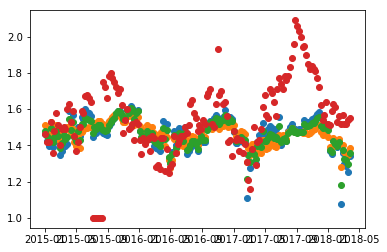

In [24]:
plt.plot_date(df_totalUS['Date'], reg.predict(x_real_test), label="Reg")
plt.plot_date(df_totalUS['Date'], lasso.predict(x_real_test), label="Lasso")
plt.plot_date(df_totalUS['Date'], ridge.predict(x_real_test), label="Ridge")

plt.plot_date(df_totalUS['Date'], df_totalUS['AveragePrice'])

In [25]:
%%HTML
<script type='text/javascript' src='https://us-east-1.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1440px; height: 683px;'><object class='tableauViz' width='1440' height='683' style='display:none;'><param name='host_url' value='https%3A%2F%2Fus-east-1.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;sangle' /><param name='name' value='Predict_plot&#47;Sheet2' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /><param name='filter' value='iframeSizedToWindow=true' /></object></div>

The price of 2017 is really unpredicable. So we do really have Avocadopocalypse

In [26]:
coef_table = pd.DataFrame()
coef_table['LR'] = reg.coef_
coef_table['Lasso'] = lasso.coef_
coef_table['Ridge'] = ridge.coef_
coef_table

,LR,Lasso,Ridge
0,-6.574255e-02,-0.000000e+00,-4.103706e-02
1,9.341593e-02,0.000000e+00,4.761171e-02
2,-3.093193e-02,-0.000000e+00,-2.144860e-02
3,3.258543e-03,0.000000e+00,1.487394e-02
4,-1.354762e-06,-2.286555e-07,-1.209498e-06
5,8.244363e-07,-2.624443e-07,7.257494e-07
6,6.834671e-07,6.366770e-09,7.855827e-07
7,-4.065554e-06,-5.099735e-06,-3.778095e-06
8,1.202889e-06,4.802008e-08,1.057285e-06
9,0.000000e+00,0.000000e+00,0.000000e+00


In [27]:
cpdf = pd.DataFrame()
cpdf['Value'] = y_test
cpdf['Ridge'] = ridge.predict(x_test)
cpdf['Lasso'] = lasso.predict(x_test)
cpdf['LR'] = reg.predict(x_test)

In [28]:
cpdf.head()

,Value,Ridge,Lasso,LR
2394,1.65,1.424005,1.450275,1.411649
3066,1.63,1.551306,1.524767,1.565167
1930,1.26,1.437704,1.398350,1.467558
3087,1.44,1.452023,1.484236,1.443511
3465,1.00,1.500662,1.521567,1.491261


In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

#plt.plot( data['Total Volume'], data['AveragePrice'],'.')

In [30]:
#from IPython.display import Image
#Image("year_plot.png")

In [31]:
#data['Money'] = data['AveragePrice']*data['Total Volume']

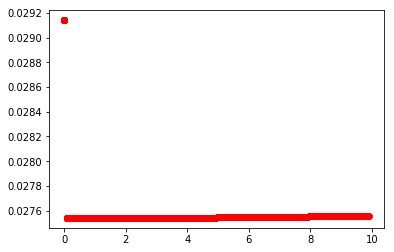

In [32]:
lasso_coef = []
index =[]
for i in range (100):
    lasso = linear_model.Lasso(alpha=0.1*i).fit(x_train, y_train)
    lasso.predict(x_test)
    lasso_coef.append( mean_squared_error(y_test, lasso.predict(x_test)))
    index.append(0.1*i)
    plt.plot(index, lasso_coef, 'ro')

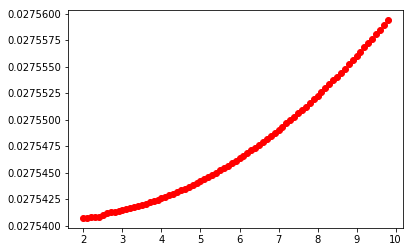

In [33]:
plt.plot(index[20:99], lasso_coef[20:99], 'ro')

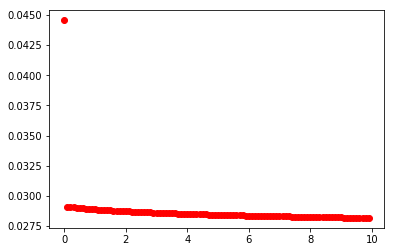

In [34]:
ridge_coef = []
index_100 =[]
for i in range (100):
    ridge = Ridge(alpha=i*0.1).fit(x_train,y_train)
    ridge.predict(x_test)
    ridge_coef.append(mean_squared_error(y_test, ridge.predict(x_test)))
    index_100.append(0.1*i)
plt.plot(index_100, ridge_coef, 'ro')

In [35]:
ridge_coef[0]

0.04456340144230768

# Region

In [36]:
data_column = data['region'].unique()

In [37]:
data_temp = data
for d in data_column:
    temp = (data['region']==d)
    data_temp[d] = temp

In [38]:
data_temp.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,...,Indianapolis,Columbus,Roanoke,Albany,Pittsburgh,BuffaloRochester,Louisville,Spokane,Boise,Syracuse
0,47,2017-02-05,0.66,11274749.11,4377537.67,2558039.85,193764.89,4145406.70,2508731.79,1627453.06,...,False,False,False,False,False,False,False,False,False,False
1,47,2017-02-05,0.67,11213596.29,3986429.59,3550403.07,214137.93,3462625.70,3403581.49,7838.83,...,False,False,False,False,False,False,False,False,False,False
2,7,2018-02-04,0.80,10894677.77,4473811.63,4097591.67,146357.78,2176916.69,2072477.62,34196.27,...,False,False,False,False,False,False,False,False,False,False
3,7,2018-02-04,0.83,10565056.41,3121272.58,3294335.87,142553.21,4006894.75,1151399.33,2838239.39,...,False,False,False,False,False,False,False,False,False,False
4,46,2016-02-07,0.70,10361698.17,2930343.28,3950852.38,424389.60,3056112.91,2693843.02,344774.59,...,False,False,False,False,False,False,False,False,False,False


In [39]:
reg

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [40]:
x = data_temp.drop(['AveragePrice','region','Date'], axis = 1)
y = data_temp.AveragePrice

x_train,x_test,y_train,y_test = train_test_split(x,y,random_state = 0)

In [41]:
reg = LinearRegression().fit(x_train, y_train)
mean_squared_error(y_test, reg.predict(x_test))

ValueError: could not convert string to float: 'conventional'

In [ ]:
lasso = linear_model.Lasso(alpha=0.1).fit(x_train, y_train)
lasso.predict(x_test)
mean_squared_error(y_test, lasso.predict(x_test))

In [ ]:
ridge = Ridge(alpha=100.0).fit(x_train,y_train)
ridge.predict(x_test)
mean_squared_error(y_test, ridge.predict(x_test))

In [ ]:
cpdf = pd.DataFrame()
cpdf['Value'] = y_test
cpdf['Ridge'] = ridge.predict(x_test)
cpdf['Lasso'] = lasso.predict(x_test)
cpdf['LR'] = reg.predict(x_test)
cpdf.head()

This proves that region helps increase model performance.

In [ ]:
ridge_coef_region = []
for i in range (100):
    ridge = Ridge(alpha=i*0.1).fit(x_train,y_train)
    ridge_coef_region.append(mean_squared_error(y_test, ridge.predict(x_test)))

plt.plot(index, ridge_coef_region, 'ro')

In [ ]:
plt.plot(index[1:99], ridge_coef_region[1:99], 'ro')

In [ ]:
ridge_coef_region

In [ ]:
lasso_coef_region = []
for i in range (100):
    lasso = linear_model.Lasso(alpha=0.1*i).fit(x_train, y_train)
    lasso_coef_region.append( mean_squared_error(y_test, lasso.predict(x_test)))

plt.plot(index, lasso_coef_region, 'ro')


In [ ]:
plt.plot(index[20:99], lasso_coef_region[20:99], 'ro')

In [ ]:
len(lasso_coef_region)

In [ ]:
x_test.head()

# Try Square root

In [ ]:
y_test_sqrt = np.sqrt(y_test)
y_train_sqrt = np.sqrt(y_train)


In [ ]:
reg_sqrt = LinearRegression().fit(x_train, y_train_sqrt)
mean_squared_error(y_test_sqrt, reg.predict(x_test))

In [ ]:
lasso_sqrt = linear_model.Lasso(alpha=0.2).fit(x_train, y_train_sqrt)
mean_squared_error(y_test_sqrt, lasso.predict(x_test))

In [ ]:
lasso_sqrt_coef_region = []
for i in range (100):
    lasso_sqrt = linear_model.Lasso(alpha=0.1*i).fit(x_train, y_train_sqrt)
    lasso_sqrt_coef_region.append( mean_squared_error(y_test_sqrt, lasso.predict(x_test)))

plt.plot(index, lasso_sqrt_coef_region, 'ro')


In [ ]:
lasso_sqrt = linear_model.Lasso(alpha=0.1).fit(x_train, y_train_sqrt)
mean_squared_error(y_test_sqrt, lasso.predict(x_test))

In [ ]:
lasso_sqrt = linear_model.Lasso(alpha=0.1).fit(x_train, y_train_sqrt)
mean_squared_error(y_test_sqrt, lasso.predict(x_test))

In [ ]:
lasso.predict(x_test)